# Analyzing NYC High School Data

# Introduction

### Preliminary

This Notebook is the conclusion of the ***Data Cleaning Project Walkthrough*** from [dataquest.io](dataquest.io). It is a guided project whose aim is to use all the techniques and skills learnt during the course. Nevertheless we are dealing with real-word data: in our case data about New York City public schools and more especially their SAT Score. The data can be found  [here](https://data.cityofnewyork.us/browse?category=Education).
> I am sometimes using blockquotes as this one, meaning that for the rest of the project I am quoting some elements given by dataquest. For the sake of simplicity and clarity, I estimated that they did not need any reformulation and were immediately usable and convenient for me and the reader.

### Context

> One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests, and whether they're unfair to certain groups. Given our prior knowledge of this topic, investigating the correlations between SAT scores and demographics might be an interesting angle to take. We could correlate SAT scores with factors like race, gender, income, and more.

> The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's fairly important to perform well on it.

> The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points (while this number has changed a few times, the data set for our project is based on 2,400 total points). Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.


>New York City makes its data on high school SAT scores available online, as well as the demographics for each high school. 

>Unfortunately, combining both of the data sets won't give us all of the demographic information we want to use. We'll need to supplement our data with other sources to do our full analysis.

>The same website has several related data sets covering demographic information and test scores. Here are the links to all of the data sets we'll be using:

>- SAT scores by school - SAT scores for each high school in New York City
>- School attendance - Attendance information for each school in New York City
>- Class size - Information on class size for each school
>- AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
>- Graduation outcomes - The percentage of students who graduated, and other outcome information
>- Demographics - Demographic information for each school
>- School survey - Surveys of parents, teachers, and students at each school


On the first part of this project we will focus on cleaning the data and combining the different sources to create a unique dataframe ***combined*** that we will use later for our analysis, and above all see if we can draw some conclusions about the correlations of some variables and the SAT score.

# Read in the data

In [1]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")


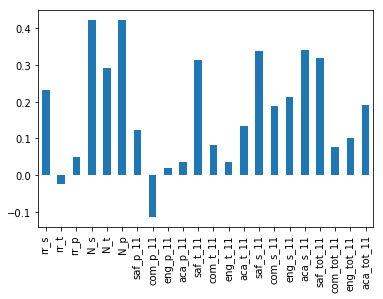

In [11]:
%matplotlib inline
correlations[survey_fields].plot.bar()


There are high correlation coefficients between the SAT score and the N_s, N_t, N_p variables which are respectively :
- the number of students respondents
- the number of teachers respondents
- the number of parents respondents

Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It makes senses as we can reasonably suppose that the higher the results, the more likely people are willing to answer the survey as it concerns "positive" outcomes.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

There are high correltions coefficients between the SAT score ant the saf_t_11, saf_s_11 (and saf_tot_11) variables which concerns the feeling of safety scores perceived by teachers, students (and the the total). It seems logical that the safer an environment is, the higher will be the results.

There is a high correlation between the SAT score and the aca_s_11 variable which indicates how the student perceives academic standards. But it is not the case for the way parents or teachers perceive the latter. (see aca_t_11 and aca_p_11 which have a less significant corellation).



### SAT score VS feeling of safety at school by students

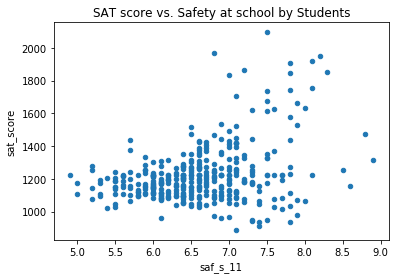

In [12]:
combined.plot(x='saf_s_11', y='sat_score', kind='scatter', 
                  title='SAT score vs. Safety at school by Students')


When we plot the SAT score versus how safety is perceived by students at school, a correlation can be seen between the two. The safer the students feel, the higher their score seems to be. But the tendency is not that obvious.

In [13]:
borough = combined.groupby("boro").agg(numpy.mean)

In [14]:
borough[["saf_s_11","sat_score"]]

,saf_s_11,sat_score
boro,,
Bronx,6.606577,1157.598203
Brooklyn,6.370755,1181.364461
Manhattan,6.831370,1278.331410
Queens,6.721875,1286.753032
Staten Island,6.530000,1382.500000


Manhattan and the Queens are the bourough with the highest safety score, whereas Brooklyn is the borough with the lowest one. Surprisingly, the Bronk has a higher safety score than Brooklyn, whereas it is rumored to be a more dangerous borough, where the crime rates are higher.

## Exploring Race and SAT scores

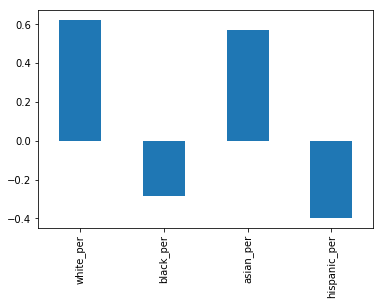

In [15]:
correlations[['white_per','black_per','asian_per','hispanic_per']].plot.bar()


The four race percentages are highly correlated with the SAT Score.

- On the one hand, we can see that it is positevely highly correlated for the White and the Asian.
- On the other hand, it is - in a lesser extend - negatively correlated for the black and the hispanic.

It could be explained by a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.


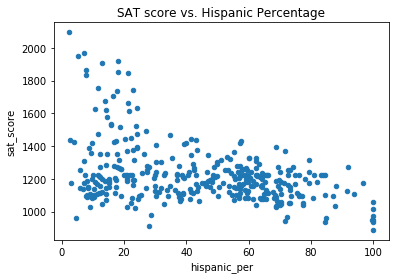

In [16]:
combined.plot(x='hispanic_per', y='sat_score', kind='scatter', 
                  title='SAT score vs. Hispanic Percentage')

The above plot clearly shows a negative correlation between the percentage of hispanic in a school and the SAT scores. The tendency is visible. The higher the hispanic percentage is, the lower the SAT score is.

In [17]:
hisp = combined[combined['hispanic_per']>95]
hisp.shape
hisp.head(10)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,0,0,0,0,0,0,"501 West 165Th\nNew York, NY 10032\n(40.838032...",40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0,0,0,0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0,0,0,0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,0,0,0,0,0,0,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"45-10 94Th Street\nElmhurst, NY 11373\n(40.743...",40.743303,-73.870575,24


In [18]:
school_list =hisp['SCHOOL NAME'].tolist()
print(school_list)

['MANHATTAN BRIDGES HIGH SCHOOL', 'WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL', 'GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MATHEMATICS', 'ACADEMY FOR LANGUAGE AND TECHNOLOGY', 'INTERNATIONAL SCHOOL FOR LIBERAL ARTS', 'PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE', 'MULTICULTURAL HIGH SCHOOL', 'PAN AMERICAN INTERNATIONAL HIGH SCHOOL']


- Manhattan Bridges is a small high school located in Hell’s Kitchen that caters to immigrants recently arrived from Spanish-speaking countries
- Washington Heights Expeditionary Learning School, better known as WHEELS, offers trips, creative projects and activities that allow children to explore the world.
- Gregorio Lupero Founded in 1994 to serve Spanish-speaking students who are new to this country
- Academy for language and technology : Safe school for new immigrants
- International school for liberal arts :  school designed to offer Spanish-speaking teens a gentle transition to English. 
- Students at Pan American International High School all speak Spanish and have been in the United States for less than four year
- Multicultural High school : serves Spanish-speaking students who have been in the United States for less than three years. 

Except the Washingtion heights expeditionary school, the rest of these schools are schools that welcome spanish-speaker students that have only been in the US for a short time, and thus do not speak English. It explains mainly with they have low SAT scores.

In [19]:
top = combined[(combined['hispanic_per']<95) & (combined['sat_score']>1800)]
top.shape
top.head(10)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.000000,2819.000000,...,0,0,0,0,0,0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02
79,05M692,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...",101,605.0,654.0,588.0,1847.0,HIGH SCHOOL FOR MATH SCIENCE ENGINEERING @ CCNY,114.000000,124.000000,...,0,0,0,0,0,0,"240 Convent Ave\nNew York, NY 10031\n(40.82112...",40.821123,-73.948845,05
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.000000,2435.000000,...,0,0,0,0,0,0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10
155,10X696,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,92,636.0,648.0,636.0,1920.0,HIGH SCHOOL OF AMERICAN STUDIES At Lehman College,194.000000,302.000000,...,0,0,0,0,0,0,"2925 Goulden Avenue\nBronx, NY 10468\n(40.8712...",40.871255,-73.897516,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.000000,3692.000000,...,0,0,0,0,0,0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0,0,0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.000000,338.000000,...,0,0,0,0,0,0,"94-50 159 Street\nJamaica, NY 11433\n(40.70099...",40.700999,-73.798154,28
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.000000,905.000000,...,0,0,0,0,0,0,"485 Clawson Street\nStaten Island, NY 10306\n(...",40.567913,-74.115362,31


In [20]:
top_school = top['SCHOOL NAME'].tolist()
print(top_school)

['BARD HIGH SCHOOL EARLY COLLEGE', 'STUYVESANT HIGH SCHOOL', 'HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGINEERING AT CITY COLLEGE', 'BRONX HIGH SCHOOL OF SCIENCE', 'HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE', 'BROOKLYN TECHNICAL HIGH SCHOOL', 'TOWNSEND HARRIS HIGH SCHOOL', 'QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE', 'STATEN ISLAND TECHNICAL HIGH SCHOOL']


All of these highschool are ***specialized high schools*** : " New York City's Specialized High Schools are selective public schools for students who excel artistically and academically. These nine schools have a separate (optional) admissions process from the general High School Admissions process. " 

## Exploring Gender and SAT SCORE

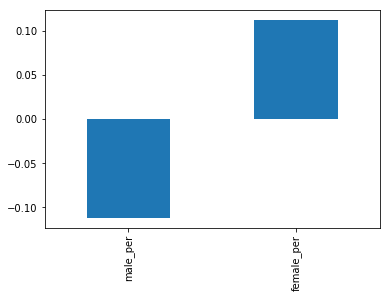

In [21]:
correlations[['male_per','female_per']].plot.bar()


There is **no significant correlation** betweeen the SAT SCORE and the male / female percentage with respectively -0.10 and 0.10 coefficients.

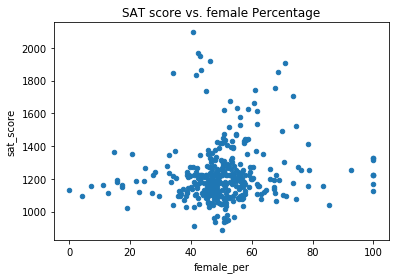

In [22]:
combined.plot(x='female_per', y='sat_score', kind='scatter', 
                  title='SAT score vs. female Percentage')

The scatter plot shows that there is not a very clear tendency of the relation between the SAT score and the female percentage. Indeed a lot of values for the female percentage are concentrated between 40 and 60 %, this accounts for the parity female/male which is mostly seen in classic schools ; the SAT scores for this range of values can vary a lot.

In [23]:
top_female = combined[(combined['female_per']>60) & (combined['sat_score']>1700)]
top_female.shape
top_female.head(10)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0,0,0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0,0,0,0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0,0,0,0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0,0,0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25


In [24]:
top_fem_schools = top_female['SCHOOL NAME'].tolist()
print(top_fem_schools)

['BARD HIGH SCHOOL EARLY COLLEGE', 'ELEANOR ROOSEVELT HIGH SCHOOL', 'BEACON HIGH SCHOOL', 'FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART AND PERFORMING ARTS', 'TOWNSEND HARRIS HIGH SCHOOL']


All of these high schools are most sought-after schools, with excellent reputation. Some of them provide arts classes to their students.

## Exploring AP Scores vs. SAT Scores

In [25]:
combined["ap_per"] = combined["AP Test Takers "] / combined['total_enrollment']

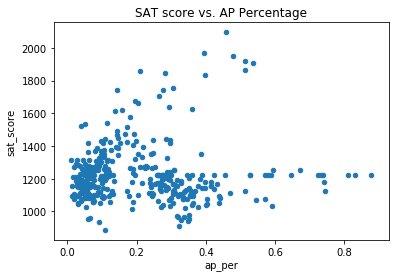

In [26]:
combined.plot(x='ap_per', y='sat_score', kind='scatter', 
                  title='SAT score vs. AP Percentage')

There is not a clear tendency for the relationship between the SAT SCORE and the AP percentage.